<a href="https://www.kaggle.com/code/ojschunky/doodles-dataset-with-convolutional-neural-network?scriptVersionId=191466707" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Doodles Dataset with Convolutional Neural Network (CNN)


![Doodle Classifier](https://storage.googleapis.com/gweb-cloudblog-publish/images/quick-draw-1u639.max-900x900.PNG)


# Overview

This notebook explores the Doodles dataset, and building a Convolutional Neural Network model to detect the type of drawing. **Note** in this example I shortened the original dataset to only include a certain subset 
of the provided doodles for runtime purposes, however, it should also work with minimal changes to the code and a lot of patience to go along with it.
:)

#### *Data Preparation*
Filter and preprocess the dataset to prepare it for model training.

Filter Data: Extract rows where the word column matches one of the desired categories ('cat', 'dog', 'bird').
Load and Preprocess Images: Convert image file paths to NumPy arrays, resize images to a fixed size, and normalize pixel values.

#### *CNN Architecture*
Define and build the CNN model for image classification.

Define Layers: Add convolutional layers, pooling layers, and fully connected layers to the model.

#### *Model Training and Fitting*

#### *Model Evaluation with Example Case*

*Dataset via ASHISH JANGRA on Kaggle*
***Jorge Nunez** 08/06/2024*

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

2024-08-07 01:09:19.108417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-07 01:09:19.108534: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 01:09:19.261854: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


#### 1.1 Loading the CSV

In [2]:
df = pd.read_csv('/kaggle/input/doodle-dataset/master_doodle_dataframe.csv')
#df = df.sample(n=1000, random_state=42)  # Sample the dataset
# List of words you want to keep
words_to_keep = ['apple', 'cat', 'dog', 'bird', 'hammer']

# Filter the DataFrame
filtered_df = df[df['word'].isin(words_to_keep)]

# Verify the filtering
print(filtered_df['word'].value_counts())  # Check the distribution of classes
df = filtered_df

print(df.shape)
df.head()

word
dog       3000
hammer    3000
cat       3000
apple     3000
bird      3000
Name: count, dtype: int64
(15000, 6)


,countrycode,drawing,key_id,recognized,word,image_path
417000,US,"[[[187, 194, 193, 176, 171, 137, 102, 83, 73, ...",5736696387731456,True,dog,data/dog/5736696387731456.png
417001,US,"[[[33, 33, 35, 54, 53, 45, 49, 73, 73, 89, 87,...",4507372158451712,True,dog,data/dog/4507372158451712.png
417002,US,"[[[67, 61, 51, 38, 25, 11, 4, 0, 0, 3, 17, 30,...",5607059879886848,True,dog,data/dog/5607059879886848.png
417003,US,"[[[0, 8, 39, 99, 160, 180, 217, 235, 240, 254,...",6175971466018816,True,dog,data/dog/6175971466018816.png
417004,SA,"[[[162, 167, 189, 198, 206, 215, 219, 220, 217...",6286201801670656,True,dog,data/dog/6286201801670656.png


#### 1.2 Preprocessing

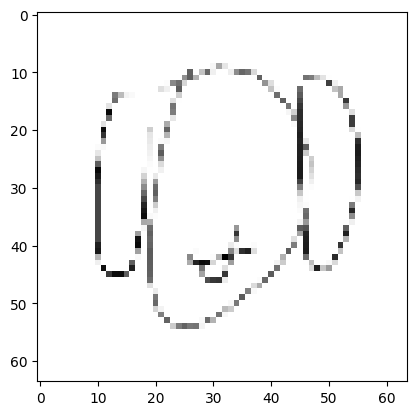

In [3]:
# Remove the 'data/' prefix from the image_path column
df['image_path'] = df['image_path'].str.replace('data/', '', regex=False)

# Verify the change
#print(df['image_path'].head())

# Load image from the 'image_path' column
def load_images(image_paths, base_path='/kaggle/input/doodle-dataset/doodle/', target_size=(64, 64)):
    images = []
    for file_path in image_paths:
        full_path = base_path + file_path
        img = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            img = cv2.resize(img, target_size)  # Resize the image to 64x64 pixels
            img = img / 255.0  # Normalize pixel values to [0, 1]
        else:
            img = np.zeros(target_size)  # If the image cannot be loaded, return a blank image
        images.append(img)
    return np.array(images)

# Apply the function to the entire 'image_path' column
image_array = load_images(df['image_path'].values)

# Display an example image using plt.imshow
plt.imshow(image_array[10], cmap='gray')
plt.show()

In [4]:
# Encode categorical 'word' column into a numerical column
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['word'])

In [5]:
X = np.stack(image_array)  # Stack all image arrays into a single numpy array

y = df['label'].values  # Labels
X.dtype

dtype('float64')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from tensorflow.keras.utils import to_categorical

num_classes = len(words_to_keep)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [8]:
from tensorflow.keras import layers, models

model = models.Sequential()

# First Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))  # 1 channel for grayscale images
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the layers before passing to the fully connected layers
model.add(layers.Flatten())

# Fully connected layer with 64 units
model.add(layers.Dense(64, activation='relu'))

# Output layer with softmax activation for multi-class classification
model.add(layers.Dense(num_classes, activation='softmax'))  # num_classes is the number of output categories

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,589 (795.27 KB)

 Trainable params: 203,589 (795.27 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [10]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.5160 - loss: 1.0988 - val_accuracy: 0.8040 - val_loss: 0.5060
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.8305 - loss: 0.4600 - val_accuracy: 0.8573 - val_loss: 0.3816
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.8625 - loss: 0.3658 - val_accuracy: 0.8760 - val_loss: 0.3521
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.8767 - loss: 0.3213 - val_accuracy: 0.8817 - val_loss: 0.3248
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.9007 - loss: 0.2767 - val_accuracy: 0.8957 - val_loss: 0.2970
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9066 - loss: 0.2431 - val_accuracy: 0.9007 - val_loss: 0.2768
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9194 - loss: 0.2135 - val_accuracy: 0.9067 - val_loss: 0.2741
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.9310 - loss: 0.1859 - 

In [11]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9043 - loss: 0.2892
Test accuracy: 0.9079999923706055


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


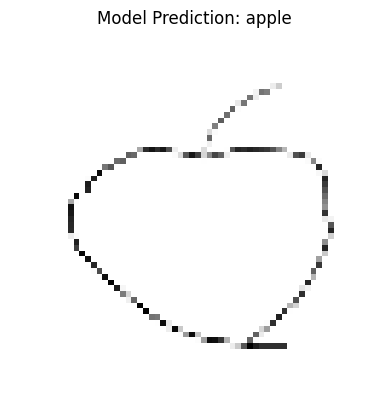

True Label: apple, Predicted Label: apple


In [12]:
# Predict on the test set
predictions = model.predict(X_test)

# Convert predictions back to label form (from one-hot encoding)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

predicted_words = encoder.inverse_transform(predicted_labels)
true_words = encoder.inverse_transform(true_labels)

# Select an index to display
index = 0  # Change this index to display a different image

# Reshape the image if necessary (assuming grayscale images of size 64x64)
plt.imshow(X_test[index].reshape(64, 64), cmap='gray')

# Set the title with the model's prediction
plt.title(f"Model Prediction: {predicted_words[index]}")
plt.axis('off')  # Hide axes for better visualization
plt.show()

# Print the true label and predicted label for verification
print(f"True Label: {true_words[index]}, Predicted Label: {predicted_words[index]}")
